In [1209]:
import pandas as pd
import numpy as np
import seaborn as sbrn
import missingno as msno
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (InputLayer, Dense, Flatten, Dropout)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

In [1210]:
data = pd.read_csv('./Dataset/House_Price_Dataset.csv')

In [1211]:
data.head()

,Suburb,Address,Rooms,Type,Price,Method,Seller,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longitude,RegionName,PropertyCount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,03/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,03/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,04/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,04/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,04/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [1212]:
data = data[~data['Price'].isnull()]

In [1213]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27247 entries, 1 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         27247 non-null  object 
 1   Address        27247 non-null  object 
 2   Rooms          27247 non-null  int64  
 3   Type           27247 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         27247 non-null  object 
 6   Seller         27247 non-null  object 
 7   Date           27247 non-null  object 
 8   Distance       27246 non-null  float64
 9   Postcode       27246 non-null  float64
 10  Rooms2         20806 non-null  float64
 11  Bathroom       20800 non-null  float64
 12  Car            20423 non-null  float64
 13  Landsize       17982 non-null  float64
 14  BuildingArea   10656 non-null  float64
 15  YearBuilt      12084 non-null  float64
 16  CouncilArea    27244 non-null  object 
 17  Latitude       20993 non-null  float64
 18  Longit

<AxesSubplot:>

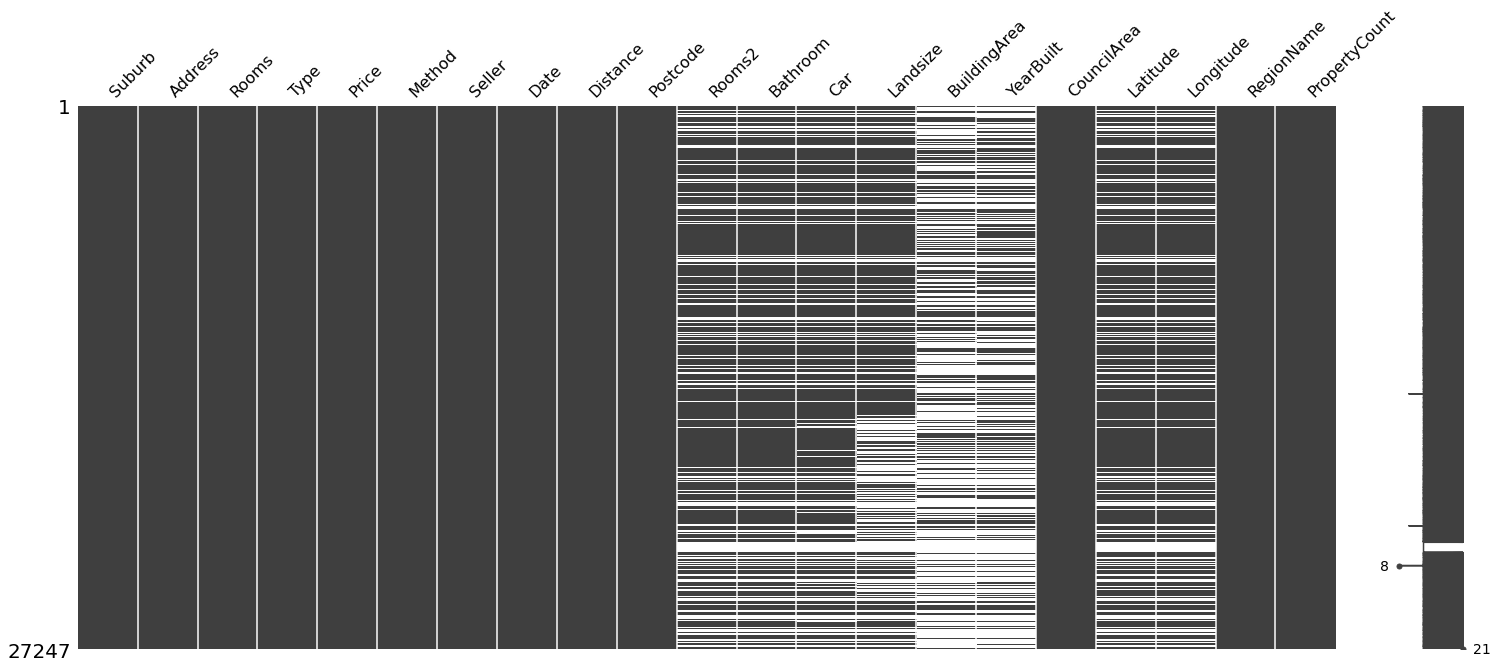

In [1214]:
msno.matrix(data)

<AxesSubplot:>

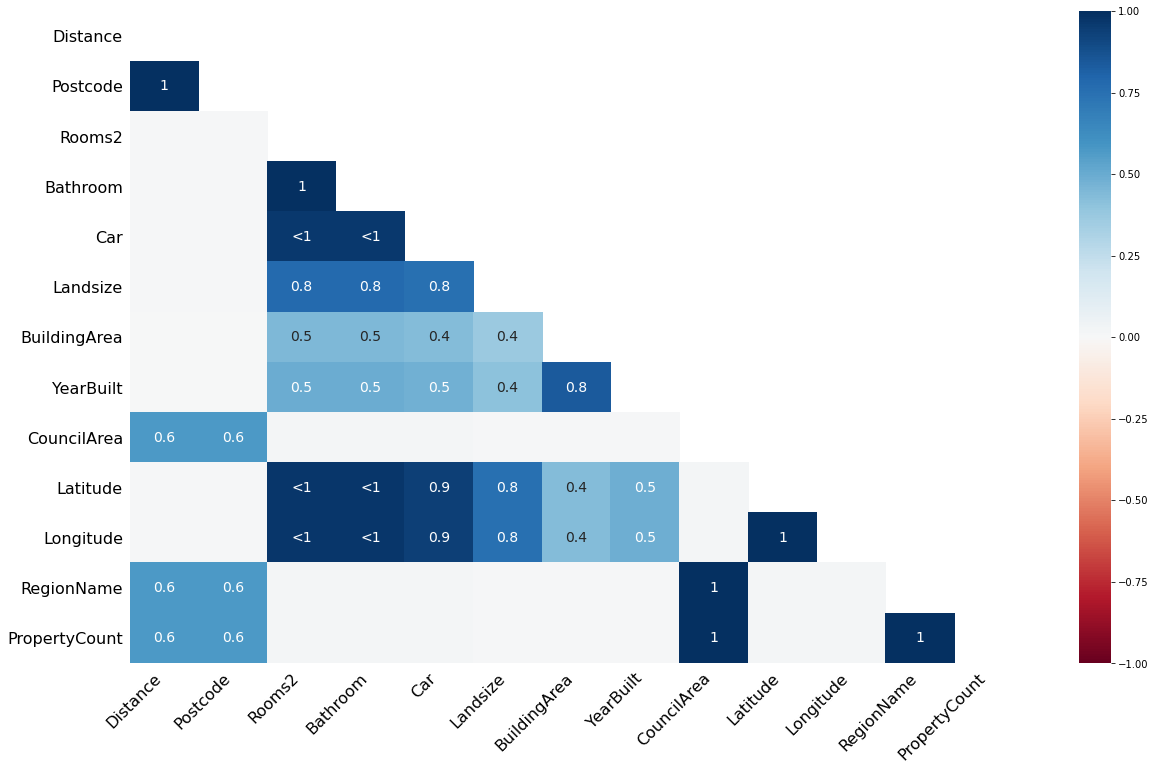

In [1215]:
msno.heatmap(data)

In [1216]:
data['Rooms'] = (data.apply(lambda row: (row.Rooms + row.Rooms2) / 2  if row.Rooms2 else row.Rooms, axis=1))

In [1217]:
data.head()

,Suburb,Address,Rooms,Type,Price,Method,Seller,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longitude,RegionName,PropertyCount
1,Abbotsford,85 Turner St,2.0,h,1480000.0,S,Biggin,03/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2.0,h,1035000.0,S,Biggin,04/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3.0,h,1465000.0,SP,Biggin,04/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0
5,Abbotsford,40 Federation La,3.0,h,850000.0,PI,Biggin,04/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4019.0
6,Abbotsford,55a Park St,3.5,h,1600000.0,VB,Nelson,04/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0


In [1218]:
data = data.drop(columns=['Date', 'Rooms2', 'Address'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27247 entries, 1 to 34856
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         27247 non-null  object 
 1   Rooms          20806 non-null  float64
 2   Type           27247 non-null  object 
 3   Price          27247 non-null  float64
 4   Method         27247 non-null  object 
 5   Seller         27247 non-null  object 
 6   Distance       27246 non-null  float64
 7   Postcode       27246 non-null  float64
 8   Bathroom       20800 non-null  float64
 9   Car            20423 non-null  float64
 10  Landsize       17982 non-null  float64
 11  BuildingArea   10656 non-null  float64
 12  YearBuilt      12084 non-null  float64
 13  CouncilArea    27244 non-null  object 
 14  Latitude       20993 non-null  float64
 15  Longitude      20993 non-null  float64
 16  RegionName     27244 non-null  object 
 17  PropertyCount  27244 non-null  float64
dtypes: flo

<AxesSubplot:>

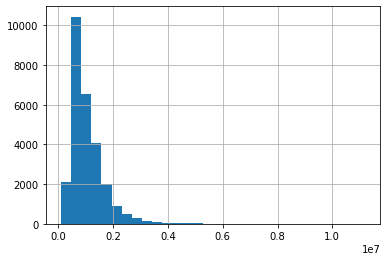

In [1219]:
data['Price'].hist(bins = 30)

In [1220]:
price_upper = data["Price"].quantile(0.99)
price_lower = data["Price"].quantile(0.01)
f'min {price_lower} — max {price_upper}'

'min 310000.0 — max 3400540.000000001'

In [1221]:
data = data[(data["Price"] < price_upper) & (data["Price"] > price_lower)]

<AxesSubplot:>

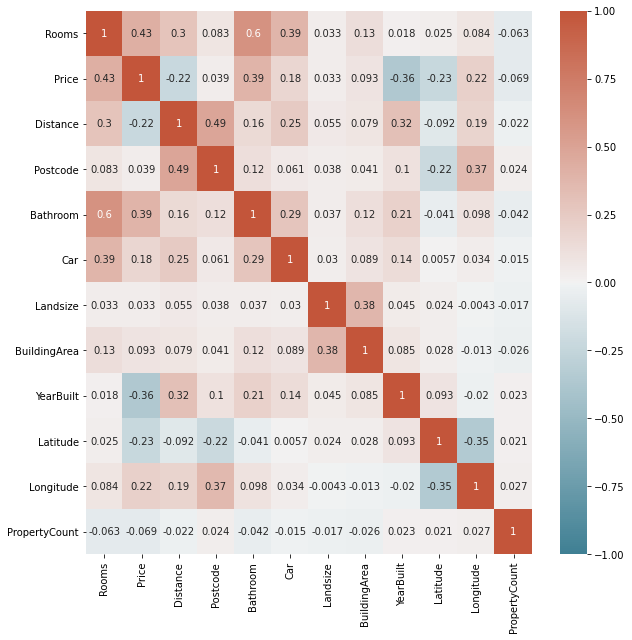

In [1222]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(10, 10))
sbrn.heatmap(corrmat, annot=True, cmap=sbrn.diverging_palette(220, 20, as_cmap=True), vmin=-1, vmax=1)

In [1223]:
data = data.drop(columns=['PropertyCount', 'Postcode'])

In [1224]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26687 entries, 1 to 34856
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Suburb        26687 non-null  object 
 1   Rooms         20393 non-null  float64
 2   Type          26687 non-null  object 
 3   Price         26687 non-null  float64
 4   Method        26687 non-null  object 
 5   Seller        26687 non-null  object 
 6   Distance      26686 non-null  float64
 7   Bathroom      20388 non-null  float64
 8   Car           20014 non-null  float64
 9   Landsize      17615 non-null  float64
 10  BuildingArea  10429 non-null  float64
 11  YearBuilt     11818 non-null  float64
 12  CouncilArea   26684 non-null  object 
 13  Latitude      20575 non-null  float64
 14  Longitude     20575 non-null  float64
 15  RegionName    26684 non-null  object 
dtypes: float64(10), object(6)
memory usage: 3.5+ MB


In [1225]:
data = data[~data['Rooms'].isnull()]
data = data[~data['Bathroom'].isnull()]
data = data[~data['Latitude'].isnull()]
data = data[~data['Longitude'].isnull()]

In [1226]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20366 entries, 1 to 34856
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Suburb        20366 non-null  object 
 1   Rooms         20366 non-null  float64
 2   Type          20366 non-null  object 
 3   Price         20366 non-null  float64
 4   Method        20366 non-null  object 
 5   Seller        20366 non-null  object 
 6   Distance      20366 non-null  float64
 7   Bathroom      20366 non-null  float64
 8   Car           19992 non-null  float64
 9   Landsize      17585 non-null  float64
 10  BuildingArea  10420 non-null  float64
 11  YearBuilt     11809 non-null  float64
 12  CouncilArea   20366 non-null  object 
 13  Latitude      20366 non-null  float64
 14  Longitude     20366 non-null  float64
 15  RegionName    20366 non-null  object 
dtypes: float64(10), object(6)
memory usage: 2.6+ MB


## Hot Encoding

In [1227]:
def hot_encoder(category, df):
    ohe = OneHotEncoder()
    print(np.unique(df[category].astype(str)))
    category_col = ohe.fit_transform(df[category].astype(str).values.reshape(-1, 1)).toarray()
    for i in range(len(category_col[0])):
        arr = []
        for x in category_col:
            arr.append(x[i])
        df[f'{category}{i}'] = arr

## Hot Encode Type

In [1228]:
hot_encoder('Type', data)

['h' 't' 'u']


## Hot Encode CouncilArea

In [1229]:
hot_encoder('CouncilArea', data)

['Banyule City Council' 'Bayside City Council' 'Boroondara City Council'
 'Brimbank City Council' 'Cardinia Shire Council' 'Casey City Council'
 'Darebin City Council' 'Frankston City Council' 'Glen Eira City Council'
 'Greater Dandenong City Council' 'Hobsons Bay City Council'
 'Hume City Council' 'Kingston City Council' 'Knox City Council'
 'Macedon Ranges Shire Council' 'Manningham City Council'
 'Maribyrnong City Council' 'Maroondah City Council'
 'Melbourne City Council' 'Melton City Council' 'Mitchell Shire Council'
 'Monash City Council' 'Moonee Valley City Council'
 'Moorabool Shire Council' 'Moreland City Council'
 'Nillumbik Shire Council' 'Port Phillip City Council'
 'Stonnington City Council' 'Whitehorse City Council'
 'Whittlesea City Council' 'Wyndham City Council' 'Yarra City Council'
 'Yarra Ranges Shire Council']


In [1230]:
data = data.drop(columns=['Type', 'Method', 'CouncilArea', 'Suburb', 'RegionName', 'Seller', 'BuildingArea'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20366 entries, 1 to 34856
Data columns (total 45 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          20366 non-null  float64
 1   Price          20366 non-null  float64
 2   Distance       20366 non-null  float64
 3   Bathroom       20366 non-null  float64
 4   Car            19992 non-null  float64
 5   Landsize       17585 non-null  float64
 6   YearBuilt      11809 non-null  float64
 7   Latitude       20366 non-null  float64
 8   Longitude      20366 non-null  float64
 9   Type0          20366 non-null  float64
 10  Type1          20366 non-null  float64
 11  Type2          20366 non-null  float64
 12  CouncilArea0   20366 non-null  float64
 13  CouncilArea1   20366 non-null  float64
 14  CouncilArea2   20366 non-null  float64
 15  CouncilArea3   20366 non-null  float64
 16  CouncilArea4   20366 non-null  float64
 17  CouncilArea5   20366 non-null  float64
 18  Counci

<AxesSubplot:>

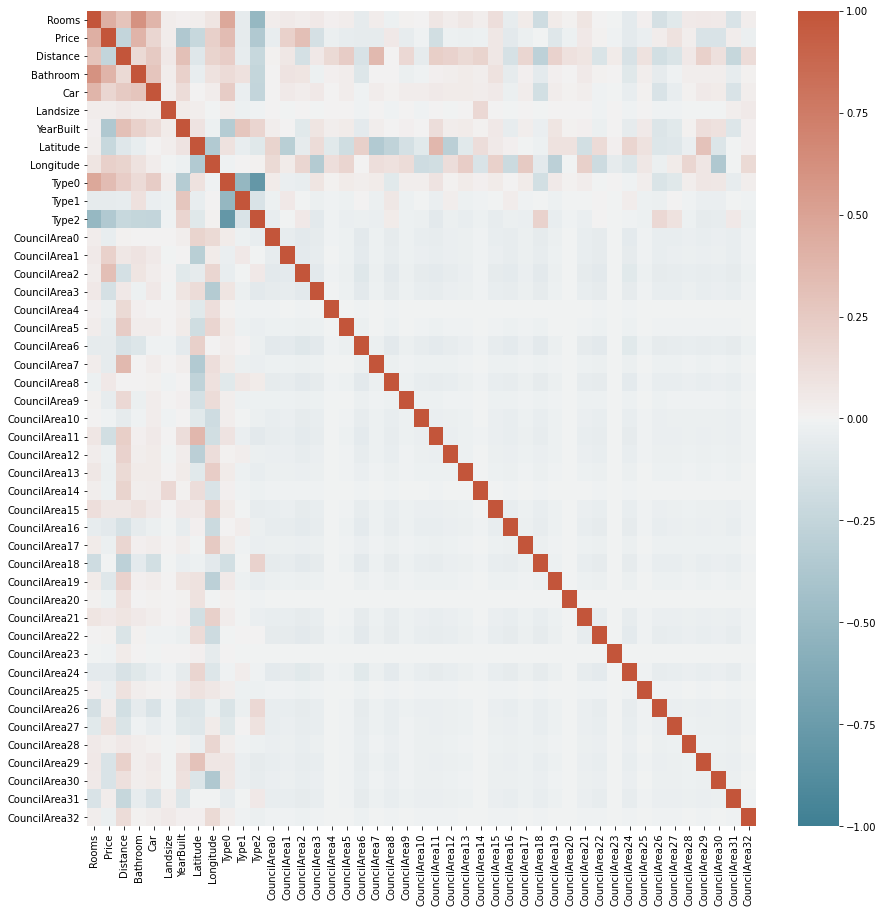

In [1231]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(15, 15))
sbrn.heatmap(corrmat, cmap=sbrn.diverging_palette(220, 20, as_cmap=True), vmin=-1, vmax=1)

In [1232]:
data['Landsize'] = data['Landsize'].replace(['0', 0], np.nan)

In [1233]:
## get non-categorical column names

def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def get_quantative(column_names):
    for x in column_names:
        if not hasNumbers(x):
            yield x

In [1234]:
def fill_null_with_mean(df, columns, from_df):
    if from_df is not None:
        for name in columns:
            df[name].fillna(from_df[name].mean(), inplace=True)
    else:
        for name in columns:
            df[name].fillna(df[name].mean(), inplace=True)

In [1235]:
Y = data['Price']
X = data.drop(columns=['Price'])

In [1236]:
quantative_columns = list(get_quantative(X.columns))

In [1237]:
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), Y.to_numpy(), test_size=0.2, shuffle=False)

In [1238]:
X_train = pd.DataFrame(data=X_train, columns=X.columns)
fill_null_with_mean(X_train, quantative_columns, None)

X_test = pd.DataFrame(data=X_test, columns=X.columns)
fill_null_with_mean(X_test, quantative_columns, X_train)

In [1239]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
x = scaler_x.fit_transform(X_train)
y = scaler_y.fit_transform(y_train.reshape(len(y_train),1))[:,0]

In [1240]:
X_scaled_test = scaler_x.transform(X_test)
y_scaled_test = scaler_y.transform(y_test.reshape(len(y_test),1))[:,0]

In [1241]:
print(x.shape)
n = x.shape[1]

(16292, 44)


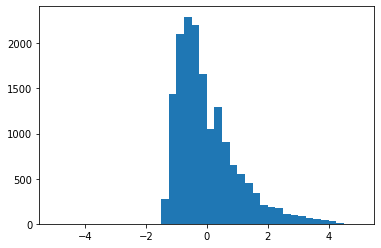

In [1242]:
fig, ax = plt.subplots()
hist = ax.hist(y, bins=40, range=[-5, 5])

In [1243]:
def sample_match(pred, real, open_pred):
    d = {'prediction': [x[0] for x in pred] if open_pred else pred, 'real': real}
    return pd.DataFrame(data=d)

# ANN

In [1244]:
model = Sequential()
model.add(Dense(96, activation='relu', input_shape=(n,)))
model.add(Dense(96, activation='relu', kernel_regularizer='l2', kernel_initializer='he_uniform'))
model.add(Dense(48, kernel_regularizer='l2', kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(48, kernel_regularizer='l2', kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(16, kernel_regularizer='l2', kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(8, kernel_regularizer='l2', kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(1, activation='linear'))

In [1245]:
model.compile(optimizer=Adam(lr=0.001), 
              loss='mean_squared_error', metrics=['mse'])

In [1246]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=0.00005)
early_stopping = EarlyStopping(monitor="val_loss", patience=7)
history = model.fit(x, y, epochs=150, batch_size=16, validation_split=0.1, 
                  callbacks=[reduce_lr, early_stopping], verbose=1)

Epoch 1/150
917/917 [==============================] - 2s 1ms/step - loss: 2.9124 - mse: 0.3985 - val_loss: 0.7893 - val_mse: 0.2918
Epoch 2/150
917/917 [==============================] - 1s 994us/step - loss: 0.6410 - mse: 0.2770 - val_loss: 0.4345 - val_mse: 0.2694
Epoch 3/150
917/917 [==============================] - 1s 999us/step - loss: 0.4382 - mse: 0.2986 - val_loss: 0.3523 - val_mse: 0.2576
Epoch 4/150
917/917 [==============================] - 1s 998us/step - loss: 0.3406 - mse: 0.2574 - val_loss: 0.3259 - val_mse: 0.2591
Epoch 5/150
917/917 [==============================] - 1s 1ms/step - loss: 0.3151 - mse: 0.2526 - val_loss: 0.3103 - val_mse: 0.2540
Epoch 6/150
917/917 [==============================] - 1s 997us/step - loss: 0.3064 - mse: 0.2525 - val_loss: 0.3102 - val_mse: 0.2608
Epoch 7/150
917/917 [==============================] - 1s 1ms/step - loss: 0.3055 - mse: 0.2558 - val_loss: 0.2915 - val_mse: 0.2440
Epoch 8/150
917/917 [==============================] - 1s 1ms

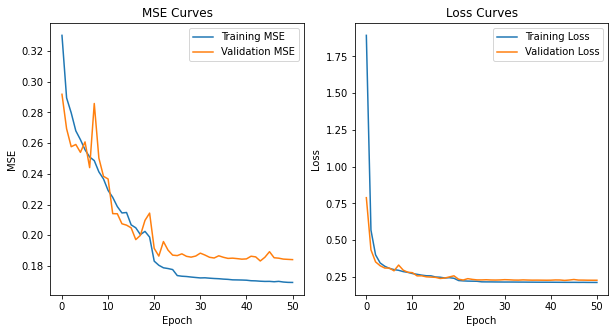

In [1247]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Training MSE',
           'Validation MSE'])
plt.title('MSE Curves')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()

In [1248]:
nn_results = model.predict(X_scaled_test)

In [1249]:
sample_match(nn_results[:25], y_scaled_test[:25], True)

,prediction,real
0,0.874364,0.734979
1,1.737552,1.081740
2,1.536284,1.152544
3,1.167427,1.310493
4,0.171093,0.371878
5,2.128173,1.107157
6,1.596878,1.533800
7,-0.894374,-0.826354
8,-1.122876,-1.116835
9,-1.071012,-1.062370


In [1250]:
r2_score(nn_results, y_scaled_test)

0.776629173333089

In [1251]:
mean_squared_error(nn_results, y_scaled_test)

0.18583526885309676

# SVM

In [1000]:
param_grid = {'C': [0.1, 1, 10, 50], 'gamma': ['scale', 1, 0.1, 0.01, 0.001], 
                  'kernel': ['rbf']}
grid = GridSearchCV(SVR(), param_grid, verbose=2, refit=True, n_jobs=-1)
grid.fit(x, y)
print(grid.best_params_)
svm = SVR(kernel=grid.best_params_['kernel'], C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [278]:
svm = SVR(kernel='rbf', C=50, gamma='scale')

In [279]:
svm.fit(x, y)

SVR(C=50)

In [280]:
svm_results = svm.predict(X_scaled_test)

In [281]:
r2_score(svm_results, y_scaled_test)

0.7183183594130187

In [282]:
sample_match(svm_results[:25], y_scaled_test[:25], False)

,prediction,real
0,0.440110,0.734979
1,1.011961,1.081740
2,0.853106,1.152544
3,0.683708,1.310493
4,0.171255,0.371878
5,1.545266,1.107157
6,1.103159,1.533800
7,-0.809704,-0.826354
8,-0.979735,-1.116835
9,-1.003648,-1.062370


## Random Forest

In [1252]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [None],
    'max_features': ['auto'],
    'min_samples_leaf': [2],
    'min_samples_split': [2],
    'n_estimators': [1500]
}
grid = GridSearchCV(RandomForestRegressor(), param_grid, verbose=2, refit=True, n_jobs=-1)
grid.fit(x, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [None],
                         'max_features': ['auto'], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [1500]},
             verbose=2)

In [1253]:
print(grid.best_params_)

{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1500}


In [1254]:
rfr = RandomForestRegressor(bootstrap=grid.best_params_['bootstrap'], max_features=grid.best_params_['max_features'], min_samples_leaf=grid.best_params_['min_samples_leaf'], min_samples_split=grid.best_params_['min_samples_split'], n_estimators=grid.best_params_['n_estimators'])

In [1255]:
rfr.fit(x, y)

RandomForestRegressor(min_samples_leaf=2, n_estimators=1500)

In [1256]:
rfr_results = rfr.predict(X_scaled_test)

In [1257]:
r2_score(rfr_results, y_scaled_test)

0.7876792080864949

In [1258]:
mean_squared_error(rfr_results, y_scaled_test)

0.16482595955083104

In [1259]:
sample_match(rfr_results[:25], y_scaled_test[:25], False)

,prediction,real
0,0.465604,0.734979
1,1.155672,1.081740
2,0.511950,1.152544
3,1.068799,1.310493
4,-0.203519,0.371878
5,1.275914,1.107157
6,1.297659,1.533800
7,-0.796231,-0.826354
8,-1.034967,-1.116835
9,-1.023911,-1.062370
